# Package Download

In [1]:
'''#from google.colab import output
!pip install yahooquery
!pip install yfinance
!pip install pykalman
#output.clear()'''

'#from google.colab import output\n!pip install yahooquery\n!pip install yfinance\n!pip install pykalman\n#output.clear()'

# Import Package

In [2]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import math
import os
import warnings
from tqdm import tqdm

import statsmodels.tsa.vector_ar.vecm as vm
from statsmodels.tsa.stattools import adfuller

import yahooquery as yq
import yfinance as yf

import heapq
import operator
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from scipy import stats
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#output.clear()
#os.chdir("/content/drive/My Drive")

%matplotlib inline

# Settings

In [3]:
# Period

StartDate = '2019-01-01'
EndDate = "2021-01-01"

#
PCA_components = 50

# Cluster size limit
CLUSTER_SIZE_LIMIT = 9999
#df size
n=1000
# 
now = True
filterTopStocks = True
#checkADF = True
leverage = 1
useNegativePairs = True
longOnly = False
minSectorLen = 0
minPairCorrel = 0.0
### ret ved machine leaning

mach = True
riskFreeYearRet = 0.03 # erstat med sveny 
pairAmount = 10000
cost = 0.0008

# Insert google Drive

In [4]:
Russel3000_tickers = [*pd.read_csv('ticker.csv', index_col=0).iloc[:, 0]]

In [5]:
#data = yf.download(Russel3000_tickers, start='2010-01-01', end='2021-01-01')['Close']
#output.clear()

In [6]:
#Price = data.iloc[1:, 10:].fillna(0)
#Price.to_csv('russel3000_allstonks_2010_2021.csv')

# Downloading Benchmark

In [7]:
#Russell = yf.download('IWV', start='2010-01-01', end='2021-01-01')['Adj Close']
# Russell.to_csv('Russell_index_ETF_2010_2021.csv')

# Download Data

In [8]:
tic = pd.read_csv('ticker-ticker.csv', index_col = 0)
#tic = tic.iloc(tic['marketcap'] 100)
tic=tic.iloc[:n,0]

tic = list(tic.index)


In [9]:
Price = pd.read_csv('russel3000_allstonks_2010_2021.csv', index_col = 0)
Russell = pd.read_csv('Russell_index_ETF_2010_2021.csv', index_col = 0)

### Visual inspection of DataFrame

In [10]:
print(f'Start of DataFrame {Price.index[0]}, end of DataFrame {Price.index[-1]}')

Start of DataFrame 2010-01-04 00:00:00, end of DataFrame 2020-12-31 00:00:00


In [11]:
print(f'Start of DataFrame {Russell.index[0]}, end of DataFrame {Russell.index[-1]}')

Start of DataFrame 2009-12-31, end of DataFrame 2020-12-31


### Setting date as index

# Daily returns calculation

In [12]:
# daily return dataframe
#df_ret = Price.pct_change().iloc[1:, :].fillna(0)
df_ret = Price#.pct_change().iloc[1:, :].fillna(0)
EndDate1 = '2020-01-01'
df_ret = df_ret.loc[StartDate:EndDate1,tic]
#
df_ret = df_ret.fillna(method='ffill')
df_ret = df_ret[df_ret.values.sum(axis=1) != 0]
df_ret = df_ret.loc[:, ~(df_ret == 0).any()]
df_ret = df_ret.pct_change().iloc[1:, :].fillna(0)
df_ret

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,JPM,V,JNJ,...,MAN,TFSL,SAIL,IRDM,SPWR,FLO,NSA,SLM,NFG,RARE
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,-0.036788,-0.099607,-0.028484,-0.025242,-0.031472,-0.029039,-0.060417,-0.022153,-0.036037,-0.015890,...,-0.020596,0.000615,-0.046083,-0.045311,-0.005917,0.010893,0.007120,0.009379,0.010812,-0.044343
2019-01-04 00:00:00,0.046509,0.042689,0.053786,0.050064,0.057697,0.047138,0.064068,0.036865,0.043081,0.016783,...,0.049435,0.027658,0.056214,0.059603,0.055555,0.008082,-0.003928,0.037166,0.024115,0.078505
2019-01-07 00:00:00,0.001275,-0.002226,-0.002167,0.034353,0.054361,0.000725,0.052941,0.000695,0.018032,-0.006415,...,0.004038,0.005383,0.042412,-0.007292,0.030075,0.003207,-0.000394,0.001120,-0.003228,0.037209
2019-01-08 00:00:00,0.007251,0.019063,0.007385,0.016612,0.001164,0.032452,-0.024895,-0.001886,0.005439,0.023227,...,0.030086,0.003569,0.020742,0.018888,-0.047445,0.007459,0.021302,-0.004474,0.017718,0.017937
2019-01-09 00:00:00,0.014300,0.016982,-0.001505,0.001714,0.009483,0.011927,0.019667,-0.001690,0.011769,-0.007926,...,0.026171,0.006520,0.002345,0.018023,0.022988,-0.007932,-0.015064,0.029214,0.002246,0.030617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00,-0.000191,0.000951,-0.003914,-0.002114,0.014384,-0.005141,-0.000838,0.002770,0.002619,-0.003483,...,-0.000826,-0.003057,0.001664,0.001185,0.020305,-0.003653,0.005837,-0.004386,-0.014973,0.017540
2019-12-26 00:00:00,0.008197,0.019840,0.012534,0.044467,0.013380,0.013017,0.002389,0.010612,0.008477,-0.000685,...,0.001654,0.000000,0.000831,-0.000394,0.028607,-0.000458,0.005803,0.003304,0.005352,-0.012656
2019-12-27 00:00:00,0.001828,-0.000379,-0.006256,0.000551,-0.001300,0.001492,-0.009699,0.000719,0.001216,-0.000549,...,0.001444,0.000000,-0.004979,-0.008287,-0.036276,-0.003210,0.000911,-0.013172,-0.001917,-0.040663


# Collecting 5 years of data for clustering

In [13]:
# 5 year return data for clustering
df_ret_train = df_ret.fillna(0)
df_ret_train.T.shape
df_ret_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_ret_train.fillna(0)

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,JPM,V,JNJ,...,MAN,TFSL,SAIL,IRDM,SPWR,FLO,NSA,SLM,NFG,RARE
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,-0.036788,-0.099607,-0.028484,-0.025242,-0.031472,-0.029039,-0.060417,-0.022153,-0.036037,-0.015890,...,-0.020596,0.000615,-0.046083,-0.045311,-0.005917,0.010893,0.007120,0.009379,0.010812,-0.044343
2019-01-04 00:00:00,0.046509,0.042689,0.053786,0.050064,0.057697,0.047138,0.064068,0.036865,0.043081,0.016783,...,0.049435,0.027658,0.056214,0.059603,0.055555,0.008082,-0.003928,0.037166,0.024115,0.078505
2019-01-07 00:00:00,0.001275,-0.002226,-0.002167,0.034353,0.054361,0.000725,0.052941,0.000695,0.018032,-0.006415,...,0.004038,0.005383,0.042412,-0.007292,0.030075,0.003207,-0.000394,0.001120,-0.003228,0.037209
2019-01-08 00:00:00,0.007251,0.019063,0.007385,0.016612,0.001164,0.032452,-0.024895,-0.001886,0.005439,0.023227,...,0.030086,0.003569,0.020742,0.018888,-0.047445,0.007459,0.021302,-0.004474,0.017718,0.017937
2019-01-09 00:00:00,0.014300,0.016982,-0.001505,0.001714,0.009483,0.011927,0.019667,-0.001690,0.011769,-0.007926,...,0.026171,0.006520,0.002345,0.018023,0.022988,-0.007932,-0.015064,0.029214,0.002246,0.030617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00,-0.000191,0.000951,-0.003914,-0.002114,0.014384,-0.005141,-0.000838,0.002770,0.002619,-0.003483,...,-0.000826,-0.003057,0.001664,0.001185,0.020305,-0.003653,0.005837,-0.004386,-0.014973,0.017540
2019-12-26 00:00:00,0.008197,0.019840,0.012534,0.044467,0.013380,0.013017,0.002389,0.010612,0.008477,-0.000685,...,0.001654,0.000000,0.000831,-0.000394,0.028607,-0.000458,0.005803,0.003304,0.005352,-0.012656
2019-12-27 00:00:00,0.001828,-0.000379,-0.006256,0.000551,-0.001300,0.001492,-0.009699,0.000719,0.001216,-0.000549,...,0.001444,0.000000,-0.004979,-0.008287,-0.036276,-0.003210,0.000911,-0.013172,-0.001917,-0.040663


In [14]:
# PCA 

N_PRIN_COMPONENTS = PCA_components
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(df_ret_train.fillna(0))

PCA(n_components=50)

In [15]:
X = pca.components_.T

In [16]:
# standardize data for clustering
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape) # 57 dimensions by adding 7 factors

(908, 50)


# DBSCAN

In [17]:
clf = DBSCAN(eps=2, min_samples=3)
print(clf)

DBSCAN(eps=2, min_samples=3)


### Number of clusters

In [18]:
#labels is label values from -1 to x
# -1 represents noisy samples that are not in clusters
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # eliminate noisy samples
print("\nClusters discovered: %d" % n_clusters_)


Clusters discovered: 4


In [19]:
clustered = clf.labels_

In [20]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=df_ret_train.columns, data=clustered.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=df_ret_train.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]


In [21]:

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 860


In [22]:
# to plot multidimension into 2D
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

In [23]:

w =np.where(X_tsne == X_tsne.min(axis=0)[0])
w_ =np.where(X_tsne == X_tsne.max(axis=0)[0])
X_tsne_ =np.delete(X_tsne, w, axis=0)
X_tsne_ =np.delete(X_tsne_, w_, axis=0)
#X_tsne.pop(X_tsne.max(axis=0))

labels_ = np.delete(labels , w)
labels_ = np.delete(labels_ , w_)
clustered_series_all_ = clustered_series_all[4:]

### DBSCAN VISUAL

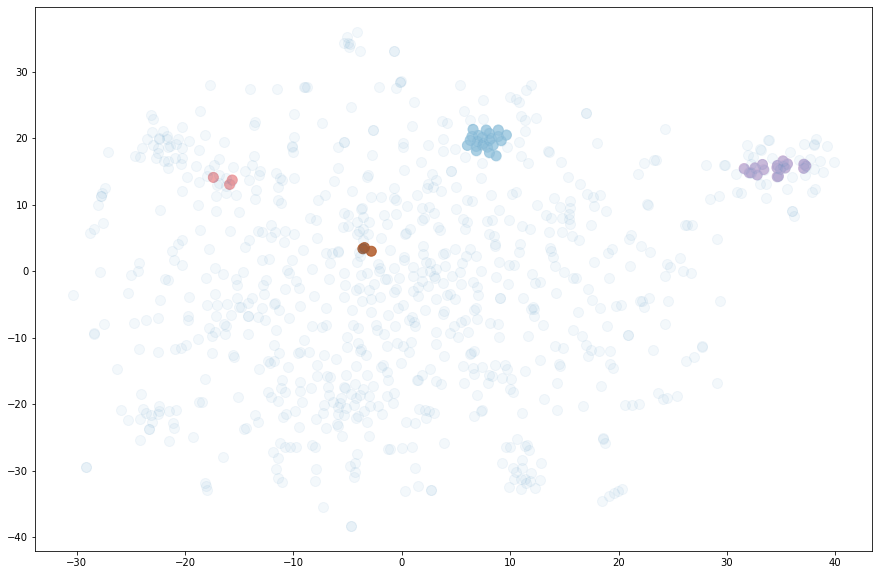

In [24]:
# PLOT
plt.figure(1, facecolor='white', figsize=(15,10))
plt.clf()
plt.axis('on')
# clustered
plt.scatter(
X_tsne_[(labels_!=-1), 0],
X_tsne_[(labels_!=-1), 1],
s=100,
alpha=0.85,
c=labels[labels!=-1],
cmap=cm.Paired
)
# unclustered in the background
plt.scatter(
X_tsne_[(clustered_series_all_==-1).values, 0],
X_tsne_[(clustered_series_all_==-1).values, 1],
s=100,
alpha=0.05
)
#plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.savefig('DB_scan_result',bbox_inches='tight')
plt.show()

### Member of clusters

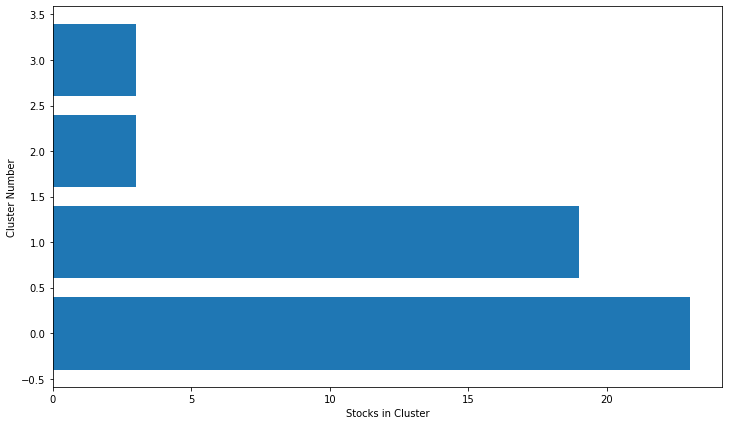

In [25]:
# show number of clusters in each cluster
plt.figure(figsize=(12,7))
plt.barh(
range(len(clustered_series.value_counts())), # cluster labels, y axis
clustered_series.value_counts()
)
#plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.savefig('Cluster_members',bbox_inches='tight')
plt.show()

### Time series Graphs

In [26]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()
clusters_viz_list = list(counts[(counts < 100) & (counts > 1)].index)[::-1]
print(clusters_viz_list)

[3, 1, 2, 0]


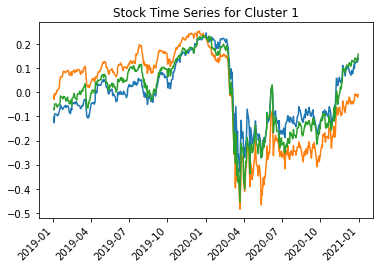

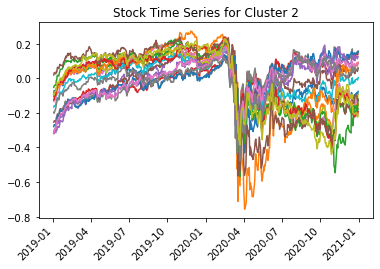

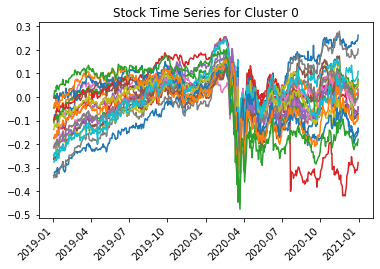

In [27]:
# let's visualize some clusters
cluster_viz_list = list(counts[(counts>1)].index)[::-1]
#fig = plt.figure(1, (7,4))
#ax = fig.add_subplot(1,1,1)
# plot a handful of the smallest clusters
for clust in cluster_viz_list[1:min(len(cluster_viz_list)+3, 8)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(Price.loc[StartDate:EndDate, tickers].mean())
    data = np.log(Price.loc[StartDate:EndDate, tickers]).sub(means)
    data.index = pd.to_datetime(data.index)
    data.plot(title='Stock Time Series for Cluster %d' % clust, rot=45, legend=False)
    ax1 = plt.axes()
    x_axis = ax1.axes.get_xaxis()
    x_axis.set_label_text('Hej')
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    ##ax.set_xticklabels([pandas_datetime.strftime("%Y-%m-%d") for pandas_datetime in pd.to_datetime(Price.index)])
plt.show()

### Optimal Pairs

In [28]:
'identify cointegrated pairs from clusters'
def Cointegration(cluster, significance, start_day, end_day):
    pair_coin = []
    p_value = []
    n = cluster.shape[0]
    keys = cluster.keys()
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = Price.loc[start_day:end_day, keys[i]]
            asset_2 = Price.loc[start_day:end_day, keys[j]]
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            if ADFtest[1] < significance:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
    return p_value, pair_coin

In [29]:
"Pair selection method"
"E_selection = True: select a pair with lowest p-value from each cluster"
"E_selection = False: select pairs among all the cluster cluster"

'E_selection = False: select pairs among all the cluster cluster'

In [30]:
def PairSelection(clustered_series, significance, start_day, end_day, E_selection):
    Opt_pairs = [] # to get best pair in cluster i
    
    if E_selection == True: # select one pair from each cluster
        for i in range(len(ticker_count_reduced)):
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day)
            if len(result[0]) > 0:
                if np.min(result[0]) < significance:
                    index = np.where(result[0] == np.min(result[0]))[0][0]
                    Opt_pairs.append([result[1][index][0], result[1][index][1]])
    else:
        p_value_contval = []
        pairs_contval = []
        for i in range(len(ticker_count_reduced)):
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day)
            if len(result[0]) > 0:
                p_value_contval += result[0]
                pairs_contval += result[1]
                
        Opt_pair_index = heapq.nsmallest(30,range(len(p_value_contval)), key=p_value_contval.__getitem__)
        Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
    return Opt_pairs

In [31]:
# Pairs with lowest p-value among all the clusters
significance = 0.05
start_day = StartDate
end_day = EndDate
E_selection = False

Opt_pairs = PairSelection(clustered_series, significance, start_day, end_day, E_selection)

In [32]:
print("Number of clusters: ",len(ticker_count_reduced))
print("Number of cointegrated pairs: ",len(Opt_pairs))
print("Pairs with lowest p-value among all the clusters:")
Opt_pairs


Number of clusters:  4
Number of cointegrated pairs:  18
Pairs with lowest p-value among all the clusters:


(['DRE', 'AMH'],
 ['AIV', 'DEI'],
 ['CMS', 'LNT'],
 ['PEG', 'DTE'],
 ['AIV', 'KRC'],
 ['ES', 'WEC'],
 ['ARE', 'AMH'],
 ['AVB', 'KRC'],
 ['EQR', 'KRC'],
 ['WEC', 'WTRG'],
 ['EGP', 'FR'],
 ['AEP', 'ATO'],
 ['ESS', 'AIV'],
 ['DTE', 'AGR'],
 ['ESS', 'KRC'],
 ['SO', 'WTRG'],
 ['D', 'AEP'],
 ['EQR', 'AIV'])

In [33]:
df = pd.DataFrame.from_dict(Opt_pairs)
tickers_pairs = [*df.iloc[:,0].unique()]+[*df.iloc[:,1].unique()]
print(len(Opt_pairs))
lst = []
for i in Opt_pairs:
    lst.append(tuple(i))
print(lst)

18
[('DRE', 'AMH'), ('AIV', 'DEI'), ('CMS', 'LNT'), ('PEG', 'DTE'), ('AIV', 'KRC'), ('ES', 'WEC'), ('ARE', 'AMH'), ('AVB', 'KRC'), ('EQR', 'KRC'), ('WEC', 'WTRG'), ('EGP', 'FR'), ('AEP', 'ATO'), ('ESS', 'AIV'), ('DTE', 'AGR'), ('ESS', 'KRC'), ('SO', 'WTRG'), ('D', 'AEP'), ('EQR', 'AIV')]


In [34]:
'''RUSSELL = ' '.join(list(set(([*df.iloc[:,0].unique()]+[*df.iloc[:,1].unique()]))))

sectorNames = ['RUSSELL']
 
sectors =[RUSSELL]
sector = sectors
sectorTickers_m = { s[0]: s[1] for s in zip(sectorNames, sectors)}

print(sectorTickers_m)'''

"RUSSELL = ' '.join(list(set(([*df.iloc[:,0].unique()]+[*df.iloc[:,1].unique()]))))\n\nsectorNames = ['RUSSELL']\n \nsectors =[RUSSELL]\nsector = sectors\nsectorTickers_m = { s[0]: s[1] for s in zip(sectorNames, sectors)}\n\nprint(sectorTickers_m)"

In [35]:
RUSSELL = ' '.join(tic)
#print(df_ret.columns)
sectorNames = ['RUSSELL']
 
sectors =[RUSSELL]
sector = sectors
sectorTickers = { s[0]: s[1] for s in zip(sectorNames, sectors)}

print(sectorTickers)

{'RUSSELL': 'MSFT AAPL GOOG AMZN TSLA FB NVDA JPM V JNJ UNH WMT HD BAC MA PG ADBE NFLX CRM DIS PFE XOM NKE ORCL TMO LLY PYPL KO ACN CSCO AVGO COST ABT PEP CVX DHR VZ MRK ABBV INTC WFC MCD UPS QCOM MS AMD T TXN INTU BX WMS NEE LOW MDT UNP SCHW HON TMUS BLK PM AXP AMAT NOW C GS RTX BMY SBUX BA TGT ISRG EL CVS AMT CHTR AMGN GE SNOW CAT TEAM DE PLD SPGI IBM ANTM MMM SQ ZTS BKNG SYK ADI ADP COP MRNA LMT GM USB LRCX MDLZ UBER SHW MU PNC ALXN GILD DASH MMC TFC CB TJX MO CME CSX CCI F DUK HCA ICE ZM ITW WDAY EW ADSK CI MCO FIS BDX EQIX APD ETN WM REGN KKR ECL FDX NSC COF FISV AON NET CL SO CRWD DXCM KLAC FCX D MRVL DDOG BSX ILMN LULU EMR NXPI PSA HUM NOC PGR U GD FTNT JCI EOG ATVI TWLO ALGN SPG MET MSCI SPOT IDXX EXC XLNX SNPS VMW DG CMG DOCU ROP MAR CVNA KDP PANW APH CDNS INFO BK IQV QTS TROW VEEV MNST A CARR ZS AIG SCCO TTD VRTX NEM EBAY MCHP APTV SLB TT PLTR KHC CTAS KMB PAYX PXD DOW DLR CNC ORLY SIVB LHX CTSH PH RSG WBA DELL MSI STZ PRU TWTR MTCH AEP O EA ODFL ROST KMI MPC OKTA ANET HLT BA

# Brazil Notebook

In [36]:
startDate = datetime.datetime.strptime(StartDate, '%Y-%m-%d')    
start1 = startDate - pd.Timedelta(days=365)
end1 = datetime.datetime.strptime(EndDate, '%Y-%m-%d')  + pd.Timedelta(days=1)
endDate = end1 - pd.Timedelta(days=365) 

In [37]:
what = 'Adj Close'
what = 'Close'
market_index = ['IWV']

In [38]:

#### To cointegration
sigPos = { 90: 0, 95: 1, 99: 2 } 

significance=90


### to adf
adfSignificance = 90

sigAdfPos = { 90: '10%', 95: '5%', 99: '1%' } 

In [39]:
def load_data(sectorTickers):

    
    debug = False
    pairList = []

    dataFolder = 'sector_data/'
    if not os.path.exists(dataFolder):
        os.makedirs(dataFolder)

    #print('Loading Sectors data:')    
    #print()

    dfIndex = None
    allSectors = dict(sectorTickers, **{ 'index' : market_index })
    sectorsDataDic = {}
    for sector in allSectors:    
        tickers = allSectors[sector]

        #print(f'Loading {sector} sector data...')    

        dataName = dataFolder+'{} data {} {}.csv'.format(sector, start1.strftime('%Y-%m-%d'), end1.strftime('%Y-%m-%d'))
        if not os.path.exists(dataName):

            dfa = yf.download(tickers, start=start1, end=end1, interval='1d') #, group_by="ticker" )

            df = dfa[what].copy()# Price.loc[StartDate:EndDate, tickers_pairs] #
            df.to_csv(dataName, index=True, header=True)

        df = pd.read_csv(dataName, header=0,
                              index_col=0,
                              parse_dates=True)     

        if sector in sectorTickers:
            sectorsDataDic[sector] = df
        else:
            dfIndex = df
    return sectorsDataDic, dfIndex

In [40]:
def clean_data(sectorsDataDic, sectorTickers):
    sectorsDataOk = {}
    sectorsTickersOk = {}    

    top100Ticker3Yrs = RUSSELL

    topTickers = top100Ticker3Yrs.split(' ') if now and filterTopStocks else None
    #print(topTickers)
    for sector in sectorTickers:    

        df = sectorsDataDic[sector]
        #print(df.head())

        df = df.fillna(method='ffill')
        df = df.iloc[1:, :]
        
        df = df.dropna(axis=1)
        #print(df.head())
        #print(df)
        if topTickers is not None:
            sTickers = list(df.columns)
            

        for ticker in sTickers:
            if ticker not in topTickers:
                df.drop(ticker, axis=1, inplace=True)
        
        sTickers = list(df.columns)

        if len(sTickers) >= minSectorLen:

            sectorsDataOk[sector] = df       
            sectorsTickersOk[sector] = sTickers

            #print(f"{sector} = ", "'{}'".format(' '.join(sTickers)))
    return sectorsDataOk, sectorsTickersOk

In [41]:
lst[0]

('DRE', 'AMH')

# Calulate Pairs Correlation

In [42]:
def calcSectorCorrelations(sector,sectorsDataOk, minPairCorrel =  0.5, mach =False):
    
    df = sectorsDataOk[sector].loc[startDate:endDate]
    cols = list(df.columns)
    n = len(cols)
    
    sectorCorr = {}
    
    #print(f'Calculating {sector} pairs correlations...')
    if mach:
        for i in range(len(lst)):
            pair = lst[i]
            corr = df[pair[0]].corr(df[pair[1]])
            sectorCorr[pair] = corr
    
    else:
        for i in range(n-1):
            for j in range(i+1, n):

                pair = (cols[i], cols[j])
                #print(pair)
                corr = df[cols[i]].corr(df[cols[j]])

                if abs(corr) >= minPairCorrel:
                    sectorCorr[pair] = corr

            #print(pair, f'corr: {sectorCorr[pair]:.4f}')

    return sectorCorr


In [43]:
def corr_pairs(sectorsDataOk, mach = False):

    if mach:
        minPairCorrel = 0
    else:
        minPairCorrel = 0.95
        
    sectorsCorrDic = {}
    sectorQty = 0
    pairQty = 0
    for sector in sectorsDataOk:    
        sectorCorrDic = calcSectorCorrelations(sector,sectorsDataOk, minPairCorrel = minPairCorrel, mach=mach  )

        #print(f"{sector} correlations = ", sectorCorrDic)
        #print(f"{sector} correlations: ")

        pairs = sectorCorrDic.keys()
        corrs = sectorCorrDic.values()

        corrSorted = sorted(zip(corrs,pairs), reverse=True)
        sectorsCorrDic[sector] = corrSorted

        sectorQty += 1
        for corr in corrSorted:
            #print( f'{corr[1]}: {corr[0]:.4f}')
            pairQty += 1
            
    #print(sectorCorrDic)

    if mach:
        d = sectorsCorrDic
        #included_keys = lst
        #sectorsCorrDic = {k:v for k,v in d.items() if k in included_keys}
        #print(sectorCorrDic)
    else: pass
            
    #print('sectors:', sectorQty)
    print('correlating pairs:', pairQty)
    
    
    return sectorsCorrDic

# Cointegratiion

In [44]:
def calcCointegration(df, pair, significance=95, mach = False ):
    
    # Combine the two time series into a matrix y2 for input into Johansen test
    y2=pd.concat([df[pair[0]], df[pair[1]]], axis=1)
    y2=y2.loc[y2.notnull().all(axis=1),]

    if (y2.shape[0] > 240):
        # Johansen test
        result=vm.coint_johansen(y2.values, det_order=0, k_ar_diff=1)
        if mach:
            isCoint = True#(result.lr1[0] > result.cvt[0, sigPos[significance]])
        else:
            isCoint = (result.lr1[0] > result.cvt[0, sigPos[significance]])
        if False: #isCoint: 
            print( pair )
            print(result.lr1)
            print(result.cvt)
            print(result.evec)    
            print()
    else:
        isCoint = False
    return isCoint, result

def cointRel(result, sigPos,mach=False, significance=99):
    return result.lr1[0] / result.cvt[0, sigPos[significance]]

def coint_pairs(sectorsDataOk, sectorsCorrDic,significance=95, mach= False):
    sectorsCointPairs = {}
    for sector in sectorsDataOk:    

        #print(f'Calculating {sector} pairs cointegrations...')

        df = sectorsDataOk[sector].loc[:endDate]

        corrs = sectorsCorrDic[sector]

        sectorCointPairs = []
        for corrPair in corrs:
            try:
                isCoint, result = calcCointegration(df, corrPair[1], significance, mach=mach)
            except:
                isCoint = False
            if isCoint:
                sectorCointPairs.append((corrPair[1], result))
        

        if len(sectorCointPairs) > 0:
            sectorsCointPairs[sector] = sectorCointPairs

    
    sectorsCointPairsSorted = {}    
    for sector in sectorsCointPairs:    

        #print( f'Sorting sector {sector}...')    

        sectorsCointPairsSorted[sector] = sorted(sectorsCointPairs[sector], key=lambda x: cointRel(x[1],sigPos,mach, significance), reverse=True)

    #print(sectorsCointPairsSorted)
    
    sectorQty = 0
    pairQty = 0
    lastPairQty = 0
    for sector in sectorsCointPairs:    
        #print( f'{sector}:')        
        for pair, result in sectorsCointPairsSorted[sector]:
            #print( f'{pair}\n{result.evec}')
            #print( f'{pair}\n{result.evec[:,0]}')
            #print( f'{pair} [{result.evec[0][0]:.4f}, {result.evec[1][0]:.4f}]')
            rel = result.evec[0][0]/result.evec[1][0]
            #if rel >= 0:
                #print( f'{pair[0]} + {rel:.4f} * {pair[1]}')
            #else:
                #print( f'{pair[0]} - {-rel:.4f} * {pair[1]}')            
            pairQty += 1

        if lastPairQty != pairQty:
            lastPairQty = pairQty
            sectorQty += 1
    
    print()        
    #print('sectors:', sectorQty)
    print('cointegrated pairs:', pairQty)    
    return sectorsCointPairs, sectorsCointPairsSorted 

# Calculate Pairs Spread and Beta

In [45]:
def spread(dfIndex, sectorsCointPairs, sectorsDataOk, sectorsCointPairsSorted, norel=False):
    
    
    dfI = dfIndex['Close'].loc[startDate:endDate]
    indexVariance = dfI.var()

    sectorQty = 0
    pairQty = 0
    lastPairQty = 0

    pairSpreadData = {}   
    pairSpreadBeta = {}
    for sector in sectorsCointPairs:    

        df = sectorsDataOk[sector]

        #print( f'Calculating spreads for sector {sector}...')        
        for pair, result in sectorsCointPairsSorted[sector]:
            if norel:
                dfSpread = df[pair[0]] +  df[pair[1]]
            else:
                rel = result.evec[0][0]/result.evec[1][0]

                dfSpread = np.log(df[pair[0]]) + rel * np.log(df[pair[1]])
            
            dfSpread = pd.DataFrame(dfSpread, columns=['spread'])
            dfSpread['neg'] = dfSpread.apply(lambda y: 1 if y['spread'] < 0 else 0, axis=1 )
            dfSpread['pos'] = dfSpread.apply(lambda y: 1 if y['spread'] > 0 else 0, axis=1 )

            allPositive = dfSpread['neg'].sum() == 0
            allNegative = dfSpread['pos'].sum() == 0
            ### RETTER HER    
            if ( allPositive or 
               ( allNegative and useNegativePairs)):

                if allNegative and useNegativePairs:
                    pairSpreadData[pair] = -dfSpread
                else:
                    pairSpreadData[pair] = dfSpread

                pairSpreadData[pair][pair[0]] = df[pair[0]]
                pairSpreadData[pair][pair[1]] = df[pair[1]]

                beta = dfI.cov(dfSpread.loc[startDate:endDate, 'spread'])/indexVariance

                pairSpreadBeta[pair] = beta

                #print(pair, f'beta={beta:5.2f}')
            
                pairQty += 1

        if lastPairQty != pairQty:
            lastPairQty = pairQty
            sectorQty += 1

    print()        
    print('sectors:', sectorQty)
    print('pairs:', pairQty)    
    return pairSpreadData, pairSpreadBeta


In [46]:
def get_hurst_exponent(pairSpreadData, max_lag=60, nohurst = False):
    
    """Returns the Hurst Exponent of the time series"""
    
    pairs = []
    num = 0
    for spr in pairSpreadData: 

        df = pairSpreadData[spr].values
        lags = range(2, max_lag)

        # variances of the lagged differences
        tau = [np.std(np.subtract(df[lag:], df[:-lag])) for lag in lags]

        # calculate the slope of the log plot -> the Hurst Exponent
        reg = np.polyfit(np.log(lags), np.log(tau), 1)
        if nohurst is True:
            pairs.append(spr)
        else:
            if reg[0] < 0.5:
                pairs.append(spr)
                num += 1
            else: pass
        
    print(f'mean reverting pairs: {num}')
    passed = { key:value for key,value in pairSpreadData.items() if key in pairs}
    return passed

# Calculate Pairs Halflife

In [47]:
def half_life(sectorsCointPairs, sectorsCointPairsSorted, pairSpreadData, NoHL=False):
    if NoHL:
        masxHalflife = 10000

    else:
        masxHalflife = 40

    sectorQty = 0
    pairQty = 0
    lastPairQty = 0

    pairSpreadHalflife = {}                        
    for sector in sectorsCointPairs:    

        #print( f'{sector}:')        
        for pair, result in sectorsCointPairsSorted[sector]:

            if pair in pairSpreadData:
                dfa = pairSpreadData[pair]
                df = pairSpreadData[pair].loc[startDate:endDate]

                yport=df['spread']
                ylag=yport.shift()
                deltaY=yport-ylag
                df2=pd.concat([ylag, deltaY], axis=1)
                df2.columns=['ylag', 'deltaY']
                regress_results=smf.ols(formula="deltaY ~ ylag", data=df2).fit() # Note this can deal with NaN in top row
                #print(regress_results.params)

                halflife=-np.log(2)/regress_results.params['ylag']

                #  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
                lookback=np.round(halflife).astype(int) #  setting lookback to the halflife found above
                if NoHL:
                    lookback = abs(lookback)
                else: pass
                if lookback < 0:
                    #print(pair, 'halflife=%.2f days' % halflife)
                    #print(pair, 'halflife < 0!!!!!!!!!!!!!!!!!!!!')
                    lookback = -lookback
                else:
                    if lookback <= masxHalflife:
                        #print(pair, 'halflife=%.2f days' % halflife)
                        pairSpreadHalflife[pair] = lookback

                        pairQty += 1

        if lastPairQty != pairQty:
            lastPairQty = pairQty
            sectorQty += 1

    print()        
    print('sectors:', sectorQty)
    print('pairs:', pairQty)    
    return pairSpreadHalflife


In [48]:
def adfValCond1(s, td, pd, adfDays):
   
    if pd > td:
        pd = 0
        
    for ad in adfDays:
        
        if ad > pd and ad <= td:
            #print( f's={s:.2f} ad={ad}, pd={pd}, td={td}')
            return s 

    return 0.0

def adfVal(w):
    x = adfuller(w, maxlag = 1)

    return x[0]-x[4][sigAdfPos[adfSignificance]]

def adfValPos(w, l, df, adfLen):
    
    l = int(l)

    if l >= adfLen-1:
        x = adfuller(df.iloc[l-adfLen+1:l+1][w], maxlag = 1)

        adf = x[0]-x[4][sigAdfPos[adfSignificance]]
        #print('adf', adf)

        return adf

    return 0.0

def adfValCond(w, l, df, adfDays, adfLen):
    
    l = int(l)

    td = df.iloc[l]['day']
    pd = df.iloc[l-1]['day'] if l > 0 else td
    if pd > td:
        pd = 0
        
    for ad in adfDays:
        
        if ad > pd and ad <= td:

            #print( f'ad={ad}, pd={pd}, td={td}')

            if l >= adfLen-1:
                x = adfuller(df.iloc[l-adfLen+1:l+1][w], maxlag = 1)

                adf = x[0]-x[4][sigAdfPos[adfSignificance]]
                #print('adf', adf)
                
                return adf

    return 0.0
def calcQtyBalAmt(df, index, prev, price, position, spread, cost_type = None):
       
    qty = df.loc[prev]['trade_qty'] 
    balance = df.loc[prev]['balance']

    if price > 0.0:
        if position > 0:   
            if qty == 0.0: # opening a long position - ok
                qty = leverage * balance / price
                df.loc[index, 'trade_qty'] = qty
                balance -= qty * price
                if cost_type == 'fixed': 
                    balance -= 5
                elif cost_type == 'share':
                    balance -= qty * price * 0.0008
                else: pass
            else: # closing a short position and opening a long position at once
                qty = -qty
                balance -= price * qty   
                if cost_type == 'fixed':
                    balance -= 5
                elif cost_type == 'share':
                    balance -= qty * price * 0.0008
                else: pass
                qty = leverage * balance / price                    
                df.loc[index, 'trade_qty'] = qty
                balance -= price * qty   
                if cost_type == 'fixed':
                    balance -= 5
                elif cost_type == 'share':
                    balance -= qty * price * 0.0008
                else: pass
        elif position == 0: # closing a short position - ok
            balance -= -price * qty
            if cost_type == 'fixed':
                balance -= 5
            elif cost_type == 'share':
                balance -= qty * price * 0.0008
            else: pass
            qty = 0
            df.loc[index, 'trade_qty'] = qty
            
        else: # error!!!
            pass
        
    elif price == 0.0:
        df.loc[index, 'trade_qty'] = qty # df.loc[prevIndex, 'trade_qty2']
        
    elif price < 0.0:
        if position == 0: # closing a long position - ok
            balance += -price * qty
            if cost_type == 'fixed':
                balance -= 5
            elif cost_type == 'share':
                balance -= qty * price * 0.0008
            else: pass
            
            qty = 0
            df.loc[index, 'trade_qty'] = qty
        elif position < 0: # opening a short position - ok
            if qty == 0.0:
                qty = leverage * balance / price
                df.loc[index, 'trade_qty'] = qty
                balance += price * qty
                if cost_type == 'fixed':
                    balance -= 5
                elif cost_type == 'share':
                    balance -= qty * price * 0.0008
                else: pass
            else: # closing a long  position and opening a short position at once
                qty = -qty
                balance += 2 * price * qty
                if cost_type == 'fixed':
                    balance -= 2 * 5
                elif cost_type == 'share':
                    balance -= 2 * qty * price * 0.0008
                else: pass
                df.loc[index, 'trade_qty'] = qty
                
        else: # error!!!
            pass



    df.loc[index, 'balance'] = balance
    df.loc[index, 'position_amt'] = price * qty / leverage if position > 0 else balance if position == 0 else balance/(1+leverage)
    df.loc[index, 'mtm_amt'] = spread * qty / leverage if position > 0 else balance if position == 0 else price*qty-(leverage*qty*(spread+price))

In [49]:




def stat_arb(df, what, lookback, std_dev,checkADF =True, start=None, end=None, adfDays=[], adfLen=252, cost_type= None):
    
    startIsNone = start is None    
    if start is None:
        start = df.index[0]
    else:
        start = df.loc[start:].index[0]

    if end is None: 
        end = df.index[-1]
    else:
        end = df.loc[:end].index[-1]
        
        
    df['moving_average'] = df[what].rolling(lookback).mean()
    df['moving_std_dev'] = df[what].rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev
    
    df['moving_avg_prev'] = df['moving_average'].shift(1)
    df['upper_band_prev'] = df['upper_band'].shift(1)
    df['lower_band_prev'] = df['lower_band'].shift(1)
    
    df['date']=[ d for d in list(df.index) ]
    prev_date = [df.index[0]] + [ d for d in list(df.index[:-1]) ]
    df['prev_date']=prev_date               

    if checkADF:

        df['day']=[ d.day for d in list(df.index) ]
        
        if False:
            prev_day = [0] + [ d.day for d in list(df.index[:-1]) ]
            df['prev_day']=prev_day               
            df['adf_score'] = df[what].rolling(window=adfTestWindowLen).apply(lambda x: adfVal(x))
            df['adf_score_cond'] = df[['adf_score', 'day', 'prev_day']].apply(lambda x: adfValCond1(x['adf_score'], x['day'], x['prev_day'], adfDays), axis=1)
        else:
            df['pos']=[ d for d in list(df.reset_index().index) ]
            df['adf_score_cond'] = df[[what, 'pos']].apply(lambda x: adfValCond(what, x['pos'], df, adfDays, adfLen), axis=1)                    
    else: 
        df['adf_score'] = 0.0
        df['adf_score_cond'] = 0.0
    
    df['prev'] = df[what].shift(1)
    
    df['long_entry'] = df.apply(lambda y: y[what] < y['lower_band'] and y['prev'] >= y['lower_band_prev'] , axis=1 )
    df['long_exit'] = df.apply(lambda y: y[what] >= y['moving_average'] and y['prev'] < y['moving_avg_prev'] , axis=1 )
    df['long_adf_exit'] = df.adf_score_cond > 0
    
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.loc[df.long_adf_exit, 'positions_long'] = 0
    df.loc[:start,'positions_long'] = 0    
    df.loc[end:,'positions_long'] = 0   
    
    df['poslong_prev'] = df['positions_long'].shift(1)
    df.poslong_prev = df.poslong_prev.fillna(method='ffill') # to prevent successive long entry signals from changing long_price
    
    df['long_price'] = df.apply(lambda y: y[what] if y['positions_long'] == 1 and y['poslong_prev'] != 1 else 
                                         -y[what] if y['positions_long'] == 0 and y['poslong_prev'] != 0 else 0, axis=1 )
    df['long_price'] = df['long_price'].replace(to_replace=0, method='ffill')

    df['long_price_prev'] = df['long_price'].shift(1)
    df['long_rets'] = df.apply(lambda y: -y['long_price']/y['long_price_prev'] if y['long_price'] < 0 and y['long_price_prev'] > 0 else 1, axis=1 )   
    df['long_wins'] = df.apply(lambda y: 1 if y['long_rets'] > 1 else 0, axis=1 )   
    df['long_loss'] = df.apply(lambda y: 1 if y['long_rets'] < 1 else 0, axis=1 )   
               
    df['short_entry'] = df.apply(lambda y: y[what] > y['upper_band'] and y['prev'] <= y['upper_band_prev'] , axis=1 )   
    df['short_exit'] = df.apply(lambda y: y[what] <= y['moving_average'] and y['prev'] > y['moving_avg_prev'] , axis=1 )          
    df['short_adf_exit'] = df.adf_score_cond > 0

    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.loc[df.short_adf_exit, 'positions_short'] = 0
    df.loc[:start,'positions_short'] = 0    
    df.loc[end:,'positions_short'] = 0    
    
    df['posshort_prev'] = df['positions_short'].shift(1)
    df.posshort_prev = df.posshort_prev.fillna(method='ffill') # to prevent successive short entry signals from changing short_price
    
    df['short_price'] = df.apply(lambda y: -y[what] if y['positions_short'] == -1 and y['posshort_prev'] != -1 else 
                                            y[what] if y['positions_short'] ==  0 and y['posshort_prev'] !=  0 else 0, axis=1 )
    df['short_price'] = df['short_price'].replace(to_replace=0, method='ffill')
        
    df['short_price_prev'] = df['short_price'].shift(1)
    df['short_rets'] = df.apply(lambda y: (2.0 + y['short_price']/y['short_price_prev']) if y['short_price'] > 0 and y['short_price_prev'] < 0 else 1, axis=1 )   
    df['short_wins'] = df.apply(lambda y: 1 if y['short_rets'] > 1 else 0, axis=1 )   
    df['short_loss'] = df.apply(lambda y: 1 if y['short_rets'] < 1 else 0, axis=1 )   
  
    df['trade_price'] = df.apply(lambda y: y['long_price']  if (y['long_price'] > 0 and y['long_price_prev'] <= 0 or
                                                                y['long_price'] < 0 and y['long_price_prev'] >= 0) else 
                                           y['short_price'] if (y['short_price'] > 0 and y['short_price_prev'] <= 0 or
                                                                y['short_price'] < 0 and y['short_price_prev'] >= 0) else 0, axis=1 )   

    
    df.positions_long = df.positions_long.fillna(method='ffill')
    df.positions_short = df.positions_short.fillna(method='ffill')
    df['positions'] = df.positions_long + df.positions_short
    df['positions_prev'] = df.positions.shift(1)
    
    df['win_rets']  = df.apply(lambda y: y['short_rets'] if y['short_rets'] > 1 else y['long_rets'] if y['long_rets'] > 1 else 1.0, axis=1 )   
    df['loss_rets'] = df.apply(lambda y: y['short_rets'] if y['short_rets'] < 1 else y['long_rets'] if y['long_rets'] < 1 else 1.0, axis=1 )   
    
    df['trade_qty'] = 0.0    
    df['position_amt'] = 0.0
    df['mtm_amt'] = 0.0
    df['balance'] = 0.0
    
    if startIsNone:    
        df.loc[start, 'balance'] = pairAmount
    else:
        prevStart = df.loc[start]['prev_date']
        df.loc[prevStart, 'balance'] = pairAmount
        
    df.loc[start:end].apply(lambda x: calcQtyBalAmt(df, x['date'], x['prev_date'], x['trade_price'], x['positions'], x[what], cost_type=cost_type), axis=1)        
        
    df['balance'] = df['balance'].replace(to_replace=0, method='ffill')
    df['position_amt'] = df['position_amt'].replace(to_replace=0, method='ffill')
    df['position_gain'] = df['position_amt'].diff() 
            
    df['ret_'+what] = (df['long_rets'] * df['short_rets']) - 1
    df['cumret_'+what] = (1 + df['ret_'+what]).cumprod() - 1
        
    df['spread_difference'] = (df.spread - df.spread.shift(1))
    df['pnl_'+what] = (df.positions_prev * df.spread_difference) / abs(df.loc[start].spread)
    df['cumpnl_'+what] = df['pnl_'+what].cumsum()
    
    return df

# Calculate Grid Search Pairs Returns

In [50]:

def grid_search_pairs_returns(pairSpreadHalflife,pairSpreadData,checkADF = True, cost_type=None):
    
    useCumRet = True
    usePosAmt = True

    std_dev=1

    if checkADF:
        adfTestWindowLen = [ 126, 252, 378, 504 ]
        adfCheckDays = [ [1], [1, 16], [1, 11, 21] ]
    else:
        adfTestWindowLen = [ 252 ]
        adfCheckDays = [ [1] ]

    pairSpreadReturnSets = {}
    
    for adfLen in adfTestWindowLen:
        for adfDays in adfCheckDays:
            opt = (adfLen, '-'.join([str(a) for a in adfDays]))
            #print()
            #print(f'Checking ADF with length {adfLen//21} months every month on day{"s" if len(adfDays)>1 else ""} {adfDays} from {endDate} to {end1}')

            pairSpreadReturns = {}
            for pair in pairSpreadHalflife:

                lookback = pairSpreadHalflife[pair]

                dfa = pairSpreadData[pair]

                dfa = stat_arb(dfa, 'spread', lookback=lookback, std_dev=std_dev,checkADF =checkADF, start=endDate, end=None, adfDays=adfDays, adfLen=adfLen, cost_type = cost_type)

                df = dfa.loc[endDate:]
               
                
                if np.std(df['pnl_spread'])*(252**0.5) == 0:
                    s=0
                else:
                    s = (np.mean(df['pnl_spread'])-(riskFreeYearRet/252))/np.std(df['pnl_spread'])*(252**0.5)
                #print(pair, 'Cumulative pnl %6.2f The Sharpe Ratio %5.2f' % (df['cumpnl_spread'].iloc[-1], s))
                if np.std(df['ret_spread'])*(252**0.5) == 0:
                    sr = 0
                else :
                    sr = (np.mean(df['ret_spread']))/np.std(df['ret_spread'])*(252**0.5)
                #print(pair, 'Cumulative ret %6.2f The Sharpe Ratio %5.2f' % (df['cumret_spread'].iloc[-1], sr))
                if np.std(df['position_gain'])*(252**0.5) == 0:
                    sp = 0
                else:
                    sp = (np.mean(df['position_gain']))/np.std(df['position_gain'])*(252**0.5)
                #print(pair, 'Final Position %6.2f The Sharpe Ratio %5.2f' % (df['position_amt'].iloc[-1], sp))
                #print()


                if usePosAmt:
                    pairSpreadReturns[pair] = (df['position_amt'].iloc[-1]-pairAmount, sp)
                elif useCumRet:
                    pairSpreadReturns[pair] = (df['cumret_spread'].iloc[-1], sr)
                else:
                    pairSpreadReturns[pair] = (df['cumpnl_spread'].iloc[-1], s)

            pairSpreadReturnSets[opt] = pairSpreadReturns
            
    return pairSpreadReturnSets

# Find best returns combination

In [51]:
def find_best_returns_combination(pairSpreadReturnSets):
    topLen = 10

    sortFieldPos = { 'pnl': 0, 'sr': 1 }

    sortField = 'sr'

    pairSpreadReturnsSorted = {}

    for opt in pairSpreadReturnSets:

        pairSpreadReturns = pairSpreadReturnSets[opt]

        pairs = list(pairSpreadReturns.keys())
        rets = list(pairSpreadReturns.values())

        pos = sortFieldPos[sortField]

        pairSpreadReturnsSorted[opt] = sorted(zip(pairs, rets), key=lambda x: x[1][pos], reverse=True)[:topLen]


    max_pnl = 0
    max_sr = 0
    for opt in pairSpreadReturnsSorted:

        #print()
        #print(f'Top {topLen} results from ADF length {opt[0]/21} months checking on day{"s" if len(opt[1])>1 else ""} {opt[1]} ')

        pnls = []
        srs = []
        for pr in pairSpreadReturnsSorted[opt]:
            pnl = pr[1][0]
            sr = pr[1][1]
            #print(pr[0], f'PnL={pnl:6.2f} Sharpe={sr:5.2f}')

            pnls.append(pnl)
            srs.append(sr)

        pnl_std = np.std(pnls)
        pnl_avg = np.mean(pnls)

        if pnl_avg > max_pnl:
            max_pnl = pnl_avg
            max_pnl_opt = opt
        else:
            max_pnl = pnl_avg
            max_pnl_opt = opt            

        sr_std = np.std(srs)
        sr_avg = np.mean(srs)

        if sr_avg > max_sr:
            max_sr = sr_avg
            max_sr_opt = opt
        else:
            max_sr = sr_avg
            max_sr_opt = opt
            
        #print(f'PnL avg={pnl_avg:6.2f} PnL stddev={pnl_std:6.2f}')
        #print(f'ShR avg={sr_avg:6.2f} ShR stddev={sr_std:6.2f}')

    return pairSpreadReturnsSorted, max_sr, max_pnl_opt


# Calculate Best PnL Option Statistics

In [52]:
def adfDays(max_pnl_opt):
    opt = max_pnl_opt # if sortField == 'pnl' else max_sr_opt

    (adfLen, adfDaysStr) = opt

    adfDays = [int(d) for d in adfDaysStr.split('-')]
    return adfDays
def calc_drawdown(cum_rets):
    cum_rets = cum_rets.apply(lambda x: 0 if abs(x) < 0.001 else x)
    # Calculate the running maximum
    running_max = cum_rets.cummax() # np.maximum.accumulate(cum_rets.dropna())
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1 
    
    return drawdown.replace(to_replace=-np.inf, method='ffill')

def calc_drawdown_df(cum_rets):
    
    cum_rets = cum_rets.apply(lambda x: 0 if abs(x) < 0.001 else x)
    # Calculate the running maximum
    running_max = cum_rets.cummax() # np.maximum.accumulate(cum_rets.dropna())
    
    dfd = pd.DataFrame( list(zip(cum_rets, running_max)), columns = ['rets', 'max'], index = cum_rets.index )

    # Calculate the percentage drawdown  
    drawdown = dfd.apply(lambda x: 0.0 if x['max'] == 0 else x['rets']/x['max'] - 1, axis=1 ).apply(lambda x: 0 if abs(x) < 0.001 else x)
    
    return drawdown.replace(to_replace=-np.inf, method='ffill')

def plot_drawdown(drawdown, w=10, h=7):
    fig = plt.figure(figsize=(w, h))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
#print()
#print(f'Recalculating returns for ADF with length {adfLen//21} months every month on day{"s" if len(adfDays)>1 else ""} {adfDays} from {endDate} to {end1}')
def Calculate_Best_PnL_Option_Statistics(pairSpreadReturnsSorted, max_sr, max_pnl_opt,pairSpreadHalflife,pairSpreadData,pairSpreadBeta, cost_type=None):
    opt = max_pnl_opt # if sortField == 'pnl' else max_sr_opt
    (adfLen, adfDaysStr) = opt
    adfDays = [int(d) for d in adfDaysStr.split('-')]
    useCumRet = True
    usePosAmt = True

    std_dev=1

    pnls = []
    srs = []
    bestPairsData = {}
    bestPairsDrawdown = {}

    cagrs = []
    hit_ratios = []
    avgP2Ls = []
    retStds = []
    maxDDs = []

    portfolioAmtDic = {}

    for pr in pairSpreadReturnsSorted[opt]:    

        pair = pr[0]

        lookback = pairSpreadHalflife[pair]

        dfa = pairSpreadData[pair]
        dfa['dd'] = 0.0    

        dfa = stat_arb(dfa, 'spread', lookback=lookback, std_dev=std_dev, start=endDate, end=None, adfDays=adfDays, adfLen=adfLen, cost_type=cost_type)

        df = dfa.loc[endDate:]
        #print(df.adf_score_cond.value_counts())

        if usePosAmt:
            pnl = (df['position_amt'].iloc[-1]-pairAmount)/pairAmount
            ret = df['mtm_amt']         # df['position_amt']        
            sr = (np.mean(df['position_gain']))/np.std(df['position_gain'])*(252**0.5)
        elif useCumRet:
            pnl = df['cumret_spread'].iloc[-1]
            ret = df['cumret_spread']
            sr = (np.mean(df['ret_spread']))/np.std(df['ret_spread'])*(252**0.5)
        else:
            pnl = df['cumpnl_spread'].iloc[-1]
            ret = df['cumpnl_spread']
            sr = (np.mean(df['pnl_spread'])-(riskFreeYearRet/252))/np.std(df['pnl_spread'])*(252**0.5)

        #dd = calc_drawdown(ret)       
        dd = calc_drawdown_df(ret)       

        portfolioAmtDic[pair] = ret

        bestPairsDrawdown[pair] = dd

        dfa.loc[endDate:, 'dd'] = dd

        bestPairsData[pair] = df

        beta = pairSpreadBeta[pair]

        cagr  = (pnl + 1)**(252/len(df))-1

        num_wins = df['long_wins'].sum() + df['short_wins'].sum() 
        num_loss = df['long_loss'].sum() + df['short_loss'].sum() 

        hit_ratio = num_wins/num_loss if num_loss > 0 else np.inf

        avg_win  =  (df['win_rets']-1).sum()/num_wins if num_wins > 0 else 0.0
        avg_loss = -(df['loss_rets']-1).sum()/num_loss if num_loss > 0 else 0.0

        avgProfitToAvgLoss = avg_win/avg_loss if avg_loss != 0 else np.inf

        retStdDev = ret.std()

        #print(pair, 'Cumulative pnl %7.2f%% The Sharpe Ratio %5.2f beta %5.2f max drawdown %5.2f%%' % (pnl*100, sr, beta, dd.min()*100))


        pnls.append(pnl)
        srs.append(sr)

        cagrs.append(cagr)
        hit_ratios.append(hit_ratio)
        avgP2Ls.append(avgProfitToAvgLoss)
        retStds.append(retStdDev)
        maxDDs.append(dd.min())


    pnl_std = np.std(pnls)
    pnl_avg = np.mean(pnls)

    sr_std = np.std(srs)
    sr_avg = np.mean(srs)

    
    print(f'PnL avg={pnl_avg*100:6.2f}% PnL stddev={pnl_std*100:6.2f}%')
    print(f'ShR avg={sr_avg:6.2f} ShR stddev={sr_std:6.2f}')    

    return pnls, srs, bestPairsData, bestPairsDrawdown, cagrs, hit_ratios, avgP2Ls, retStds, maxDDs, portfolioAmtDic, sr_avg, sr_std

In [53]:
def make_dfs(cagrs, hit_ratios, avgP2Ls, retStds, maxDDs, pairSpreadReturnsSorted, max_pnl_opt):
    cols = ['CAGR', 'Success Ratio of Trades', 'Average Profit to Average Loss', 'Standard Deviation of Returns', 'Maximum Draw-down']
    cols = ['CAGR', 'Hit Ratio', 'Avg Profit/Loss', 'Rets StdDev', 'Max Draw-down']
    opt = max_pnl_opt
    dfs = pd.DataFrame(list(zip(cagrs, hit_ratios, avgP2Ls, retStds, maxDDs)), 
                       columns = cols,
                       index = [ pr[0] for pr in pairSpreadReturnsSorted[opt]] ).sort_values('CAGR', ascending=False)
    print(f' We have: {dfs.shape[0]} selected pairs')
    return dfs
'''
print(f"{'Pair':29}", '\t'.join([f'{c:9}' for c in cols]))    
for index, row in dfs.reset_index().iterrows():
    print(str(row[0]), '\t'.join([f'{i:9.2f}' for i in list(row[1:-1])]), f'\t{list(row)[-1]*100:9.2f}%')
'''

'\nprint(f"{\'Pair\':29}", \'\t\'.join([f\'{c:9}\' for c in cols]))    \nfor index, row in dfs.reset_index().iterrows():\n    print(str(row[0]), \'\t\'.join([f\'{i:9.2f}\' for i in list(row[1:-1])]), f\'\t{list(row)[-1]*100:9.2f}%\')\n'

In [54]:
def print_shit(portfolioAmtDic, show = None):
    dfPort = pd.DataFrame(portfolioAmtDic)

    numPairs = len(dfPort.columns)

    initialAmount = pairAmount*numPairs

    dfPort['portfolio'] = np.sum(dfPort, axis=1)
    dfPort['portfolio_rets'] = dfPort['portfolio'].pct_change()

    dd = calc_drawdown_df(dfPort['portfolio'])

    pnl = (dfPort['portfolio'].iloc[-1]-initialAmount)/initialAmount

    cagr  = (pnl + 1)**(252/len(dfPort))-1

    stdDev = dfPort['portfolio_rets'].std()

    maxDD = dd.min()

    print()
    print(f'Porfolio rets: {pnl:.4f} CAGR: {cagr:.4f} StdDev: {stdDev:.4f} Max DrawDown: {maxDD:.4f}')
    print()
    if show=='yes':
        dfPort['portfolio'].plot(figsize=(10, 5))
        plt.show()

        plot_drawdown(dd)
    else: pass
    return dfPort, dd, pnl, cagr, stdDev, maxDD

# Print Charts

In [55]:
def print_Charts(bestPairsData, bestPairsDrawdown):
    w=10
    h=5

    for pair in bestPairsData:

        df = bestPairsData[pair]
        dd = bestPairsDrawdown[pair]

        s = np.mean(df['pnl_spread'])/np.std(df['pnl_spread'])*(252**0.5)
        print(pair, 'Cumulative pnl %7.2f The Sharpe Ratio %5.2f' % (df['cumpnl_spread'].iloc[-1], s))
        sr = (np.mean(df['ret_spread']))/np.std(df['ret_spread'])*(252**0.5)
        print(pair, 'Cumulative ret %7.2f The Sharpe Ratio %5.2f' % (df['cumret_spread'].iloc[-1], sr))


        # Plot the spread
        df[[pair[0], pair[1]]].plot(figsize=(w, h)) #, color=['lightskyblue', 'orange', 'green', 'red'])
        plt.ylabel("Spread")
        plt.show()

        print(pair, 'Cumulative pnl %7.2f The Sharpe Ratio %5.2f' % (df['cumpnl_spread'].iloc[-1], s))
        df[['cumpnl_spread', 'spread', 'moving_average', 'upper_band', 'lower_band', 'positions_prev']].plot(figsize=(w, h), color=['fuchsia', 'lightskyblue', 'orange', 'green', 'red', 'gray'], secondary_y='cumpnl_spread')
        plt.ylabel("cumpnl_spread")
        plt.show()

        print(pair, 'Cumulative ret %7.2f The Sharpe Ratio %5.2f' % (df['cumret_spread'].iloc[-1], sr))
        df[['cumret_spread', 'spread', 'moving_average', 'upper_band', 'lower_band', 'positions_prev']].plot(figsize=(w, h), color=['fuchsia', 'lightskyblue', 'orange', 'green', 'red', 'gray'], secondary_y='cumret_spread')
        plt.ylabel("cumret_spread")
        plt.show()

        print(pair, 'Cumulative ret %7.2f The Sharpe Ratio %5.2f' % (df['cumret_spread'].iloc[-1], sr))
        df[['position_amt', 'spread', 'trade_price', 'positions']].plot(figsize=(w, h), color=['fuchsia', 'lightskyblue', 'darkseagreen', 'gray'], secondary_y='position_amt')
        plt.show()

        print(pair, 'Cumulative ret %7.2f The Sharpe Ratio %5.2f' % (df['cumret_spread'].iloc[-1], sr))
        df[['mtm_amt', 'position_amt', 'spread', 'trade_price', 'positions']].plot(figsize=(w, h), color=['fuchsia', 'orange', 'lightskyblue', 'darkseagreen', 'gray'], secondary_y=['mtm_amt', 'position_amt'])
        plt.show()

        plot_drawdown(dd, w, h)


# Execute

In [56]:
def execute(sectorTickers,NoHL=False,checkADF=True,cost_type =None,norel =False, mach= False, nohurst= False):
    try:
        '''
        Use cost type = fixed str type. if a fixed cost
        Use cost_type = share if basic point commision
        Use mach = true if macine leaned cointegration
        Use sectorTickers = sectorTicker_m if mach is true'''
        print('step 1/12')
        print('load data')
        sectorsDataDic, dfIndex = load_data(sectorTickers)
        #print(sectorsDataDic)
        print('step 2/12')
        print('clean data')
        sectorsDataOk, sectorsTickersOk = clean_data(sectorsDataDic, sectorTickers)
        #print(sectorsDataOk)
        print('step 3/12')
        print('correlation')
        sectorsCorrDic = corr_pairs(sectorsDataOk, mach = mach)
        print('step 4/12')
        print('cointegration')
        sectorsCointPairs, sectorsCointPairsSorted = coint_pairs(sectorsDataOk, sectorsCorrDic,significance=99,mach = mach)
        print('step 5/12')
        print('spread and beta')
        pairSpreadData, pairSpreadBeta = spread(dfIndex, sectorsCointPairs, sectorsDataOk, sectorsCointPairsSorted, norel)
        print('step 6/12')
        pairSpreadData_H = get_hurst_exponent(pairSpreadData, max_lag=60, nohurst=nohurst)
        print('half life')
        pairSpreadHalflife = half_life(sectorsCointPairs, sectorsCointPairsSorted, pairSpreadData_H, NoHL)    
        print('step 7/12')
        print('grid search')
        pairSpreadReturnSets = grid_search_pairs_returns( pairSpreadHalflife,pairSpreadData_H,checkADF, cost_type)
        print('step 8/12')
        print('best pairs')
        pairSpreadReturnsSorted, max_sr, max_pnl_opt = find_best_returns_combination(pairSpreadReturnSets)
        print('step 9/12')
        print('profit and loss')
        pnls, srs, bestPairsData, bestPairsDrawdown, cagrs, hit_ratios, avgP2Ls, retStds, maxDDs, portfolioAmtDic, sr_avg, sr_std = Calculate_Best_PnL_Option_Statistics(pairSpreadReturnsSorted, max_sr, max_pnl_opt,pairSpreadHalflife,pairSpreadData,pairSpreadBeta, cost_type)
        print('step 10/12')
        print('make df')
        dfs = make_dfs(cagrs, hit_ratios, avgP2Ls, retStds, maxDDs, pairSpreadReturnsSorted, max_pnl_opt)
        print('step 11/12')
        print('print cumulative return')
        dfPort, dd, pnl, cagr, stdDev, maxDD = print_shit(portfolioAmtDic)
        print('step 12/12')
        print('print pairs stuff')
        #print_Charts(bestPairsData, bestPairsDrawdown)

        return  dd, pnl, cagr, stdDev, maxDD, dfs, sr_avg, sr_std, dfPort
    except: 
        dd=0,
        pnl= 0,
        cagr=0,
        stdDev=0,
        maxDD=0, 
        dfs=0, 
        sr_avg=0, 
        sr_std=0, 
        dfPort = 0
        return dd, pnl, cagr, stdDev, maxDD, dfs, sr_avg, sr_std, dfPort
        
    

# Full Cointegraton selection

In [57]:
dd1, pnl1, cagr1, stdDev1, maxDD1, dfs1, sr_avg1, sr_std1, dfPort1= execute(sectorTickers,NoHL=False,checkADF=True,cost_type =None,norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg= 60.42% PnL stddev= 57.63%
ShR avg=  1.46 ShR stddev=  0.41
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.6042 CAGR: 0.6012 StdDev: 0.0118 Max DrawDown: -0.1386

step 12/12
print pairs stuff


# With 5 doller commision

In [58]:

dd1f, pnl1f, cagr1f, stdDev1f, maxDD1f, dfs1f, sr_avg1f, sr_std1f, dfPort1f  = execute(sectorTickers,NoHL=False,checkADF=True,cost_type ='fixed',norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg= 56.06% PnL stddev= 56.97%
ShR avg=  1.43 ShR stddev=  0.40
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.5606 CAGR: 0.5578 StdDev: 0.0118 Max DrawDown: -0.1395

step 12/12
print pairs stuff


# with 8 basic point commision

In [59]:
dd1s, pnl1s, cagr1s, stdDev1s, maxDD1s, dfs1s, sr_avg1s, sr_std1s, dfPort1s = execute(sectorTickers,NoHL=False,checkADF=True,cost_type ='share',norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg= 58.58% PnL stddev= 56.67%
ShR avg=  1.45 ShR stddev=  0.40
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.5858 CAGR: 0.5829 StdDev: 0.0118 Max DrawDown: -0.1390

step 12/12
print pairs stuff


# Cointegration no ADF

In [60]:
dd12, pnl12, cagr12, stdDev12, maxDD12, dfs12, sr_avg12, sr_std12, dfPort12 = execute(sectorTickers,NoHL=False,checkADF=False,cost_type =None,norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=111.87% PnL stddev=188.72%
ShR avg=  1.53 ShR stddev=  0.51
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1187 CAGR: 1.1124 StdDev: 0.0207 Max DrawDown: -0.2264

step 12/12
print pairs stuff


# With fixed 5 dollar commision

In [61]:
dd12f, pnl12f, cagr12f, stdDev12f, maxDD12f, dfs12f, sr_avg12f, sr_std12f, dfPort12f = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='fixed',norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=107.53% PnL stddev=186.59%
ShR avg=  1.50 ShR stddev=  0.51
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.0753 CAGR: 1.0693 StdDev: 0.0208 Max DrawDown: -0.2290

step 12/12
print pairs stuff


# With 8 basic point commision

In [62]:
dd12s, pnl12s, cagr12s, stdDev12s, maxDD12s, dfs12s, sr_avg12s, sr_std12s, dfPort12s = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='share',norel =False, mach= False, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 97
half life

sectors: 1
pairs: 63
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=109.87% PnL stddev=187.28%
ShR avg=  1.52 ShR stddev=  0.50
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.0987 CAGR: 1.0926 StdDev: 0.0207 Max DrawDown: -0.2275

step 12/12
print pairs stuff


# Cointegration No ADF & Hurst

In [63]:
dd13, pnl13, cagr13, stdDev13, maxDD13, dfs13, sr_avg13, sr_std13, dfPort13 = execute(sectorTickers,NoHL=False,checkADF=False,cost_type =None,norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 69
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=117.05% PnL stddev=186.72%
ShR avg=  1.57 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1705 CAGR: 1.1639 StdDev: 0.0206 Max DrawDown: -0.2230

step 12/12
print pairs stuff


In [64]:
dd13f, pnl13f, cagr13f, stdDev13f, maxDD13f, dfs13f, sr_avg13f, sr_std13f, dfPort13f = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='fixed',norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 69
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=112.53% PnL stddev=184.65%
ShR avg=  1.54 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1253 CAGR: 1.1190 StdDev: 0.0207 Max DrawDown: -0.2258

step 12/12
print pairs stuff


In [65]:
dd13s, pnl13s, cagr13s, stdDev13s, maxDD13s, dfs13s, sr_avg13s, sr_std13s, dfPort13s = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='share',norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 69
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=114.98% PnL stddev=185.32%
ShR avg=  1.56 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1498 CAGR: 1.1433 StdDev: 0.0206 Max DrawDown: -0.2242

step 12/12
print pairs stuff


# Cointegration process no HL & ADF & Hurst


In [66]:
dd14, pnl14, cagr14, stdDev14, maxDD14, dfs14, sr_avg14, sr_std14, dfPort14 = execute(sectorTickers,NoHL=True,checkADF=False,cost_type =None,norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 109
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=117.05% PnL stddev=186.72%
ShR avg=  1.57 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1705 CAGR: 1.1639 StdDev: 0.0206 Max DrawDown: -0.2230

step 12/12
print pairs stuff


# With 5 dollar commision

In [67]:
dd14f, pnl14f, cagr14f, stdDev14f, maxDD14f, dfs14f, sr_avg14f, sr_std14f, dfPort14f = execute(sectorTickers,NoHL=True,checkADF=False,cost_type ='fixed',norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 109
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=112.53% PnL stddev=184.65%
ShR avg=  1.54 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1253 CAGR: 1.1190 StdDev: 0.0207 Max DrawDown: -0.2258

step 12/12
print pairs stuff


# With 8 basic point commission

In [68]:
dd14s, pnl14s, cagr14s, stdDev14s, maxDD14s, dfs14s, sr_avg14s, sr_std14s, dfPort14s =  execute(sectorTickers,NoHL=True,checkADF=False,cost_type ='share',norel =False, mach= False, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 2069
step 4/12
cointegration

cointegrated pairs: 118
step 5/12
spread and beta

sectors: 1
pairs: 109
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 109
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=114.98% PnL stddev=185.32%
ShR avg=  1.56 ShR stddev=  0.49
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 1.1498 CAGR: 1.1433 StdDev: 0.0206 Max DrawDown: -0.2242

step 12/12
print pairs stuff


# DBscan selection full process

In [69]:
dd21, pnl21, cagr21, stdDev21, maxDD21, dfs21, sr_avg21, sr_std21, dfPort21 = execute(sectorTickers,NoHL=False,checkADF=True,cost_type =None,norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  5.33% PnL stddev=  5.23%
ShR avg=  1.05 ShR stddev=  0.05
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0533 CAGR: 0.0531 StdDev: 0.0038 Max DrawDown: -0.0337

step 12/12
print pairs stuff


# with 5 dollar commision

In [70]:
dd21f, pnl21f, cagr21f, stdDev21f, maxDD21f, dfs21f, sr_avg21f, sr_std21f, dfPort21f =execute(sectorTickers,NoHL=False,checkADF=True,cost_type ='fixed',norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  3.12% PnL stddev=  5.24%
ShR avg=  1.02 ShR stddev=  0.05
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0312 CAGR: 0.0311 StdDev: 0.0038 Max DrawDown: -0.0346

step 12/12
print pairs stuff


# with 8 basic point commision

In [71]:
dd21s, pnl21s, cagr21s, stdDev21s, maxDD21s, dfs21s, sr_avg21s, sr_std21s, dfPort21s = execute(sectorTickers,NoHL=False,checkADF=True,cost_type ='share',norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  5.15% PnL stddev=  5.20%
ShR avg=  1.04 ShR stddev=  0.05
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0515 CAGR: 0.0513 StdDev: 0.0038 Max DrawDown: -0.0337

step 12/12
print pairs stuff


# DBscan no AFD

In [72]:
dd22, pnl22, cagr22, stdDev22, maxDD22, dfs22, sr_avg22, sr_std22, dfPort22 = execute(sectorTickers,NoHL=False,checkADF=False,cost_type =None,norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  6.24% PnL stddev=  9.29%
ShR avg=  1.06 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0624 CAGR: 0.0622 StdDev: 0.0038 Max DrawDown: -0.0366

step 12/12
print pairs stuff


# with 5 dollar commision

In [73]:
dd22f, pnl22f, cagr22f, stdDev22f, maxDD22f, dfs22f, sr_avg22f, sr_std22f, dfPort22f =execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='fixed',norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  4.48% PnL stddev=  9.24%
ShR avg=  1.04 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0448 CAGR: 0.0447 StdDev: 0.0038 Max DrawDown: -0.0398

step 12/12
print pairs stuff


# with 8 basic point commision

In [74]:
dd22s, pnl22s, cagr22s, stdDev22s, maxDD22s, dfs22s, sr_avg22s, sr_std22s, dfPort22s = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='share',norel =False, mach= True, nohurst= False)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 18
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  5.92% PnL stddev=  9.23%
ShR avg=  1.05 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0592 CAGR: 0.0590 StdDev: 0.0038 Max DrawDown: -0.0380

step 12/12
print pairs stuff


# DBscan no ADF & Hurst

In [75]:
dd23, pnl23, cagr23, stdDev23, maxDD23, dfs23, sr_avg23, sr_std23, dfPort23 = execute(sectorTickers,NoHL=False,checkADF=False,cost_type =None,norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  6.24% PnL stddev=  9.29%
ShR avg=  1.06 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0624 CAGR: 0.0622 StdDev: 0.0038 Max DrawDown: -0.0366

step 12/12
print pairs stuff


In [76]:
dd23f, pnl23f, cagr23f, stdDev23f, maxDD23f, dfs23f, sr_avg23f, sr_std23f, dfPort23f = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='fixed',norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  4.48% PnL stddev=  9.24%
ShR avg=  1.04 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0448 CAGR: 0.0447 StdDev: 0.0038 Max DrawDown: -0.0398

step 12/12
print pairs stuff


In [77]:
dd23s, pnl23s, cagr23s, stdDev23s, maxDD23s, dfs23s, sr_avg23s, sr_std23s, dfPort23s = execute(sectorTickers,NoHL=False,checkADF=False,cost_type ='share',norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  5.92% PnL stddev=  9.23%
ShR avg=  1.05 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0592 CAGR: 0.0590 StdDev: 0.0038 Max DrawDown: -0.0380

step 12/12
print pairs stuff


# BDscan no Halflife, no ADF & Hurst

In [78]:
dd24, pnl24, cagr24, stdDev24, maxDD24, dfs24, sr_avg24, sr_std24, dfPort24 = execute(sectorTickers,NoHL=True,checkADF=False,cost_type =None,norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  6.24% PnL stddev=  9.29%
ShR avg=  1.06 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0624 CAGR: 0.0622 StdDev: 0.0038 Max DrawDown: -0.0366

step 12/12
print pairs stuff


# with 5 dollar commision

In [79]:
dd24f, pnl24f, cagr24f, stdDev24f, maxDD24f, dfs24f, sr_avg24f, sr_std24f, dfPort24f = execute(sectorTickers,NoHL=True,checkADF=False,cost_type ='fixed',norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  4.48% PnL stddev=  9.24%
ShR avg=  1.04 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0448 CAGR: 0.0447 StdDev: 0.0038 Max DrawDown: -0.0398

step 12/12
print pairs stuff


# with 8 basic point commision

In [80]:
dd24s, pnl24s, cagr24s, stdDev24s, maxDD24s, dfs24s, sr_avg24s, sr_std24s, dfPort24s = execute(sectorTickers,NoHL=True,checkADF=False,cost_type ='share',norel =False, mach= True, nohurst= True)

step 1/12
load data
step 2/12
clean data
step 3/12
correlation
correlating pairs: 18
step 4/12
cointegration

cointegrated pairs: 18
step 5/12
spread and beta

sectors: 1
pairs: 18
step 6/12
mean reverting pairs: 0
half life

sectors: 1
pairs: 18
step 7/12
grid search
step 8/12
best pairs
step 9/12
profit and loss
PnL avg=  5.92% PnL stddev=  9.23%
ShR avg=  1.05 ShR stddev=  0.09
step 10/12
make df
 We have: 10 selected pairs
step 11/12
print cumulative return

Porfolio rets: 0.0592 CAGR: 0.0590 StdDev: 0.0038 Max DrawDown: -0.0380

step 12/12
print pairs stuff


In [81]:
row1 =[pnl1, cagr1, stdDev1, maxDD1, sr_avg1, sr_std1]
row2 =[pnl1f, cagr1f, stdDev1f, maxDD1f, sr_avg1f, sr_std1f]
row3 =[pnl1s, cagr1s, stdDev1s, maxDD1s, sr_avg1s, sr_std1s]
row4 =[pnl12, cagr12, stdDev12, maxDD12, sr_avg12, sr_std12]
row5 =[pnl12f, cagr12f, stdDev12f, maxDD12f, sr_avg12f, sr_std12f]
row6 =[pnl12s, cagr12s, stdDev12s, maxDD12s, sr_avg12s, sr_std12s]
row7 =[pnl13, cagr13, stdDev13, maxDD13, sr_avg13, sr_std13]
row8 =[pnl13f, cagr13f, stdDev13f, maxDD13f, sr_avg13f, sr_std13f]
row9 =[pnl13s, cagr13s, stdDev13s, maxDD13s, sr_avg13s, sr_std13s]
row10 =[pnl14, cagr14, stdDev14, maxDD14, sr_avg14, sr_std14]
row11 =[pnl14f, cagr14f, stdDev14f, maxDD14f, sr_avg14f, sr_std14f]
row12 =[pnl14s, cagr14s, stdDev14s, maxDD14s, sr_avg14s, sr_std14s]
row13 =[pnl21, cagr21, stdDev21, maxDD21, sr_avg21, sr_std21]
row14 =[pnl21f, cagr21f, stdDev21f, maxDD21f, sr_avg21f, sr_std21f]
row15 =[pnl21s, cagr21s, stdDev21s, maxDD21s, sr_avg21s, sr_std21s]
row16 =[pnl22, cagr22, stdDev22, maxDD22, sr_avg22, sr_std22]
row17 =[pnl22f, cagr22f, stdDev22f, maxDD22f, sr_avg22f, sr_std22f]
row18 =[pnl22s, cagr22s, stdDev22s, maxDD22s, sr_avg22s, sr_std22s]
row19 =[pnl23, cagr23, stdDev23, maxDD23, sr_avg23, sr_std23]
row20 =[pnl23f, cagr23f, stdDev23f, maxDD23f, sr_avg23f, sr_std23f]
row21=[pnl23s, cagr23s, stdDev23s, maxDD23s, sr_avg23s, sr_std23s]
row22 =[pnl24, cagr24, stdDev24, maxDD24, sr_avg24, sr_std24]
row23 =[pnl24f, cagr24f, stdDev24f, maxDD24f, sr_avg24f, sr_std24f]
row24 =[pnl24s, cagr24s, stdDev24s, maxDD24s, sr_avg24s, sr_std24s]

data = {'': ['Profit loss', 'CAGR', 'CAGR standard dev', 'Max Drawdown', 'Sharpe ratio', 'Shape ratio standard dev'],
        'Full': row1,
        'Full + fix': row2,
        'Full + share': row3,
        '-ADF': row4,
        '-ADF + fix': row5,
        '-ADF + share': row6,
        '-ADF - Hurst': row7,
        '-ADF - Hurst + fix': row8,
        '-ADF - Hurst + share': row9,
        '-ADF - HL - Hurst': row10,
        '-ADF - HL - Hurst + fix': row11,
        '-ADF - HL - Hurst + share': row12,
        'DBscan full': row13,
        'DBscan full + fix': row14,
        'DBscan full + share': row15,
        'DBscan - ADF': row16,
        'DBscan - ADF + fix': row17,
        'DBscan - ADF + share': row18,
        'DBscan - ADF - Hurst': row19,
        'DBscan - ADF - Hurst + fix': row20,
        'DBscan - ADF - Hurst + share': row21,
        'DBscan - ADF - HL - Hurst': row22,
        'DBscan - ADF - HL - Hurst + fix': row23,
        'DBscan - ADF - HL - Hurst + share': row24
        }

dat = {
        'Full dd': dd1,
        'Full port': dfPort1['portfolio'],
        'Full + fix dd': dd1f,
        'Full + fix port':dfPort1f['portfolio'],
        'Full + share dd': dd1s,
        'Full + share port': dfPort1s['portfolio'],
        '-ADF dd': dd12,
        '-ADF port': dfPort12['portfolio'],
        '-ADF + fix dd': dd12f,
        '-ADF + fix port': dfPort12f['portfolio'],
        '-ADF + share dd': dd12s,
        '-ADF + share port':dfPort12s['portfolio'],
        '-ADF - Hurst dd': dd13,
        '-ADF - Hurst port': dfPort13['portfolio'],
        '-ADF - Hurst + fix dd': dd13f,
        '-ADF - Hurst + fix port': dfPort13f['portfolio'],
        '-ADF - Hurst + share dd': dd13s,
        '-ADF - Hurst + share port': dfPort13s['portfolio'], 
        '-ADF - HL - Hurst dd': dd14,
        '-ADF - HL - Hurst port': dfPort14['portfolio'],
        '-ADF - HL - Hurst + fix dd': dd14f, 
        '-ADF - HL - Hurst + fix port': dfPort14f['portfolio'],
        '-ADF - HL - Hurst + share dd': dd14s,
        '-ADF - HL - Hurst + share port': dfPort14s['portfolio'],
        'DBscan Full dd': dd21,
        'DBscan Full port': dfPort21['portfolio'],
        'DBscan Full + fix dd': dd21f,
        'DBscan Full + fix port':dfPort21f['portfolio'],
        'DBscan Full + share dd': dd21s,
        'DBscan Full + share port': dfPort21s['portfolio'],
        'DBscan -ADF dd': dd22,
        'DBscan -ADF port': dfPort22['portfolio'],
        'DBscan -ADF + fix dd': dd22f,
        'DBscan -ADF + fix port': dfPort22f['portfolio'],
        'DBscan -ADF + share dd': dd22s,
        'DBscan -ADF + share port':dfPort22s['portfolio'],
        'DBscan -ADF - Hurst dd': dd23,
        'DBscan -ADF - Hurst port': dfPort23['portfolio'],
        'DBscan -ADF - Hurst + fix dd': dd23f,
        'DBscan -ADF - Hurst + fix port': dfPort23f['portfolio'],
        'DBscan -ADF - Hurst + share dd': dd23s,
        'DBscan -ADF - Hurst + share port': dfPort23s['portfolio'], 
        'DBscan -ADF - Hurst - HL dd': dd24,
        'DBscan -ADF - Hurst - HL port': dfPort24['portfolio'],
        'DBscan -ADF - Hurst - HL + fix dd': dd24f, 
        'DBscan -ADF - Hurst - HL + fix port': dfPort24f['portfolio'],
        'DBscan -ADF - Hurst - HL + share dd': dd24s,
        'DBscan -ADF - Hurst - HL + share dd': dfPort24s['portfolio'],
       
      
        }


df_final = pd.DataFrame(data)
df_final = df_final.set_index('')
df_final.to_csv('df_final_19_21.csv')

df_plots = pd.DataFrame(dat)
df_plots.to_csv('df_plots_19_21.csv')

<AxesSubplot:xlabel='Date'>

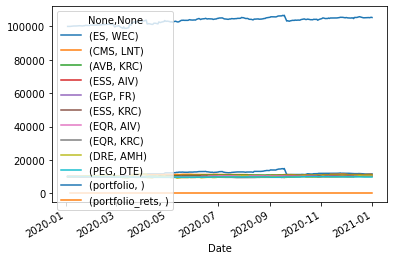

In [82]:
dfPort21.plot()